# Eksperimen CNN - Klasifikasi Klepon vs Putu

**Notebook ini telah dikonfigurasi untuk reproducibility:**
- Random seed telah di-set untuk memastikan hasil yang konsisten
- Setiap kali dijalankan ulang akan menghasilkan hasil yang sama
- PENTING: Jalankan semua cell secara berurutan dari atas ke bawah

---

# 0. Import Library

# Setup Random Seed untuk Reproducibility

Set random seed agar hasil training konsisten setiap kali dijalankan ulang.

In [1]:
# ============================================================
# SET RANDOM SEED UNTUK REPRODUCIBILITY
# ============================================================
# Dengan mengatur random seed, hasil training akan konsisten
# setiap kali notebook dijalankan ulang dengan kondisi yang sama
# ============================================================

SEED = 42

# Set seed untuk Python random
import random
random.seed(SEED)

# Set seed untuk NumPy
import numpy as np
np.random.seed(SEED)

# Set seed untuk TensorFlow/Keras
import tensorflow as tf
tf.random.set_seed(SEED)

# Set seed untuk OS (untuk beberapa operasi level sistem)
import os
os.environ['PYTHONHASHSEED'] = str(SEED)

# ============================================================
# KONFIGURASI GPU MEMORY UNTUK MENGHINDARI OOM ERROR
# ============================================================
# Mengatur GPU memory growth agar tidak mengalokasikan semua memory sekaligus
# dan menggunakan mixed precision untuk efisiensi memory

# Set GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU Memory Growth enabled untuk {len(gpus)} GPU")
    except RuntimeError as e:
        print(f"⚠ Warning: {e}")

# Enable mixed precision untuk efisiensi memory (optional tapi sangat membantu)
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print("✓ Mixed Precision (float16) enabled untuk efisiensi memory")

print("="*60)
print("✓ RANDOM SEED & GPU CONFIGURATION BERHASIL")
print("="*60)
print(f"   Seed Value: {SEED}")
print(f"   GPU Available: {len(gpus) if gpus else 0}")
print(f"   Mixed Precision: Enabled (float16)")
print(f"   Status: Reproducibility ENABLED")
print("="*60)

An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


c:\Users\RAFFI\.conda\envs\py39\lib\site-packages\google\api_core\_python_version_support.py:252: FutureWarning: You are using a Python version (3.9.23) past its end of life. Google will update google.api_core with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)


✓ GPU Memory Growth enabled untuk 1 GPU
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6
✓ Mixed Precision (float16) enabled untuk efisiensi memory
✓ RANDOM SEED & GPU CONFIGURATION BERHASIL
   Seed Value: 42
   GPU Available: 1
   Mixed Precision: Enabled (float16)
   Status: Reproducibility ENABLED
✓ Mixed Precision (float16) enabled untuk efisiensi memory
✓ RANDOM SEED & GPU CONFIGURATION BERHASIL
   Seed Value: 42
   GPU Available: 1
   Mixed Precision: Enabled (float16)
   Status: Reproducibility ENABLED


In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
# Setup ImageDataGenerator untuk load gambar dari dataframe
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# Confusion Matrix dan Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout

# 1. Load Dataset

In [3]:
dataset_path = "dataset"
folder_klepon = os.path.join(dataset_path, "klepon")
folder_putu   = os.path.join(dataset_path, "Putu")

count_klepon = len(os.listdir(folder_klepon))
count_putu   = len(os.listdir(folder_putu))
total = count_klepon + count_putu

print(f"Jumlah gambar klepon: {count_klepon}")
print(f"Jumlah gambar putu  : {count_putu}")
print(f"Total gambar         : {total}")

Jumlah gambar klepon: 500
Jumlah gambar putu  : 500
Total gambar         : 1000


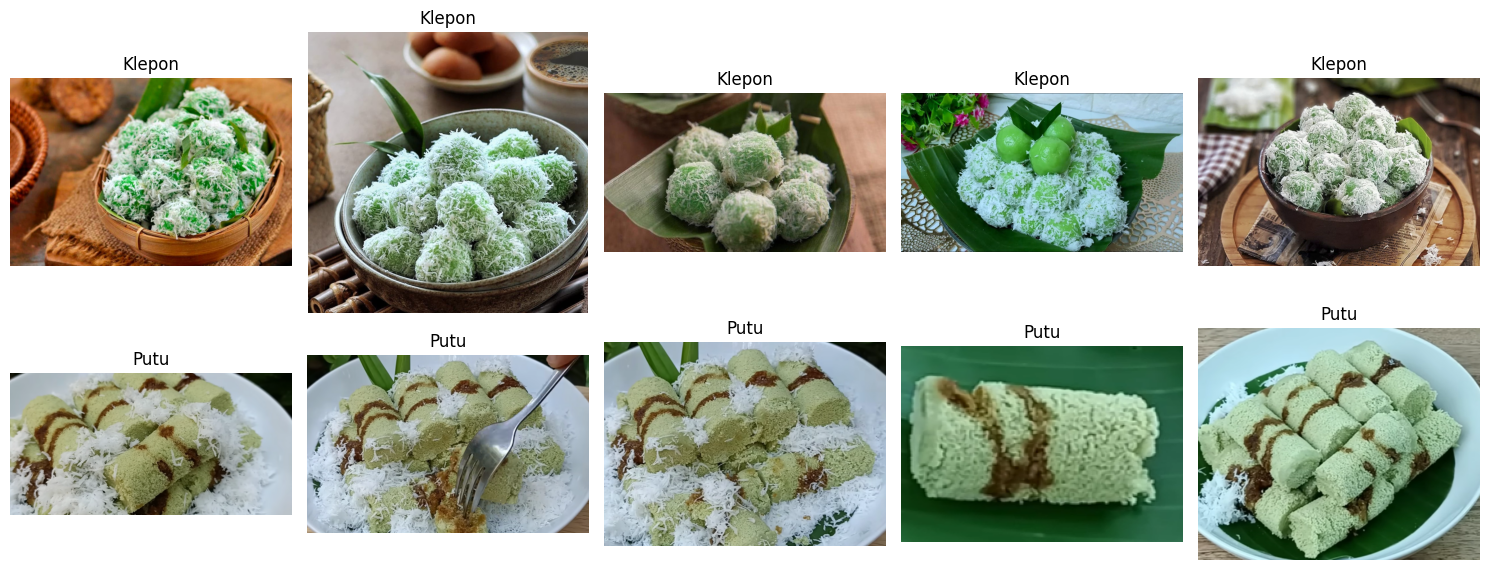

In [4]:
# Ambil list file
klepon_files = sorted(os.listdir(folder_klepon))[:5]
putu_files = sorted(os.listdir(folder_putu))[:5]

# Total gambar = 10 → 2 baris × 5 kolom
plt.figure(figsize=(15, 6))

# --- Gambar Klepon ---
for i, fname in enumerate(klepon_files):
    img_path = os.path.join(folder_klepon, fname)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title("Klepon")
    plt.axis("off")

# --- Gambar Putu ---
for i, fname in enumerate(putu_files):
    img_path = os.path.join(folder_putu, fname)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(img)
    plt.title("Putu")
    plt.axis("off")

plt.tight_layout()
plt.show()

# 2. Load Data dari CSV dan Preprocessing

In [5]:
# Load metadata CSV
df = pd.read_csv("metadata.csv")

print(f"Total data: {len(df)}")
print(f"\nDistribusi label:")
print(df['label'].value_counts())
print(f"\nContoh 5 data pertama:")
print(df.head())

Total data: 1000

Distribusi label:
label
0    500
1    500
Name: count, dtype: int64

Contoh 5 data pertama:
                           path  label
0  dataset\klepon\01_klepon.jpg      0
1  dataset\klepon\02_klepon.jpg      0
2  dataset\klepon\03_klepon.jpg      0
3  dataset\klepon\04_klepon.jpg      0
4  dataset\klepon\05_klepon.jpg      0


In [6]:
# Split data: 70% train, 15% validation, 15% test
# Dengan stratified split untuk memastikan distribusi seimbang

# Step 1: Split 70% train dan 30% temp (untuk val + test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=SEED, stratify=df['label'])

# Step 2: Split 30% temp menjadi 15% validation dan 15% test (50-50 dari temp)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['label'])

# Konversi label integer menjadi string untuk compatibility dengan flow_from_dataframe
train_df = train_df.copy()
val_df = val_df.copy()
test_df = test_df.copy()

train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

print(f"Total data: {len(df)}")
print(f"\nData training   : {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Data validation : {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Data testing    : {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\n{'='*50}")
print("Distribusi Label Training:")
print(train_df['label'].value_counts().sort_index())
print(f"\nDistribusi Label Validation:")
print(val_df['label'].value_counts().sort_index())
print(f"\nDistribusi Label Testing:")
print(test_df['label'].value_counts().sort_index())

Total data: 1000

Data training   : 700 (70.0%)
Data validation : 150 (15.0%)
Data testing    : 150 (15.0%)

Distribusi Label Training:
label
0    350
1    350
Name: count, dtype: int64

Distribusi Label Validation:
label
0    75
1    75
Name: count, dtype: int64

Distribusi Label Testing:
label
0    75
1    75
Name: count, dtype: int64


In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 16  # Reduced from 32 to 16 untuk mengurangi memory usage

# ========================================
# GENERATOR DENGAN PREPROCESSING (Rescaling)
# ========================================

# Generator untuk training (dengan rescaling)
train_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk validation (hanya rescaling, tanpa augmentasi)
val_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk testing (hanya rescaling, tanpa augmentasi)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generator dari dataframe - TRAINING
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

# Create generator dari dataframe - VALIDATION
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Create generator dari dataframe - TESTING
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ========================================
# GENERATOR TANPA PREPROCESSING (Raw Pixels)
# ========================================

# Generator tanpa rescaling - Training
train_datagen_no_prep = ImageDataGenerator()

# Generator tanpa rescaling - Validation
val_datagen_no_prep = ImageDataGenerator()

# Generator tanpa rescaling - Testing
test_datagen_no_prep = ImageDataGenerator()

# Create generator dari dataframe - TRAINING (No Prep)
train_generator_no_prep = train_datagen_no_prep.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

# Create generator dari dataframe - VALIDATION (No Prep)
val_generator_no_prep = val_datagen_no_prep.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Create generator dari dataframe - TESTING (No Prep)
test_generator_no_prep = test_datagen_no_prep.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("="*60)
print("✓ DATA GENERATORS BERHASIL DIBUAT")
print("="*60)
print(f"   Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE} (reduced untuk memory efficiency)")
print(f"   Training samples: {len(train_df)}")
print(f"   Validation samples: {len(val_df)}")
print(f"   Test samples: {len(test_df)}")
print("="*60)
print("✓ Generator dengan preprocessing (rescaling) siap")
print("✓ Generator tanpa preprocessing (raw pixels) siap")
print("="*60)

Found 700 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 700 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 700 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
✓ DATA GENERATORS BERHASIL DIBUAT
   Image Size: 128x128
   Batch Size: 16 (reduced untuk memory efficiency)
   Training samples: 700
   Validation samples: 150
   Test samples: 150
✓ Generator dengan preprocessing (rescaling) siap
✓ Generator tanpa preprocessing (raw pixels) siap
Found 150 validated image filenames belonging to 2 classes.
✓ DATA GENERATORS BERHASIL DIBUAT
   Image Size: 128x128
 

# 3. Eksperimen dengan 6 Konfigurasi Model × 2 Kondisi Preprocessing = 12 Eksperimen

Membandingkan 6 konfigurasi model:
1. **CNN Dasar (Baseline)** - Model sederhana 2 Conv blocks
2. **CNN + Augmentasi Data** - Menambahkan data augmentation
3. **Arsitektur Lebih Dalam (VGG-like)** - Lebih banyak layer konvolusi
4. **Transfer Learning (MobileNetV2)** - Menggunakan MobileNetV2 pretrained
5. **Transfer Learning (ResNet50)** - Menggunakan ResNet50 pretrained
6. **R-CNN (Region-based CNN)** - CNN dengan region proposal simulation

Setiap konfigurasi dijalankan dengan **2 kondisi preprocessing**:
- **Dengan Preprocessing**: Rescaling pixel values (0-1)
- **Tanpa Preprocessing**: Raw pixel values (0-255)

**Total: 6 × 2 = 12 eksperimen**

Semua model menggunakan **Early Stopping** untuk efisiensi training.

---

**⚠️ PENTING - Memory Management:**
- Batch size telah dikurangi menjadi 16 (dari 32) untuk menghindari OOM error
- Mixed precision (float16) digunakan untuk efisiensi memory
- Memory akan dibersihkan setelah setiap model selesai training
- Jika masih terjadi OOM, restart kernel dan jalankan ulang dari awal

In [8]:
# Dictionary untuk menyimpan semua hasil eksperimen
experiment_results = {}

# Setup Early Stopping untuk semua eksperimen
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

EPOCHS_EXP = 50  # Max epochs, tapi akan stop early jika tidak ada improvement

## 3.1. Konfigurasi 1 - CNN Dasar (Baseline)

Model sederhana dengan 2 Conv blocks.

In [9]:
# ============================================================
# HELPER FUNCTION: CLEAR MEMORY
# ============================================================
# Fungsi untuk membersihkan memory setelah training model
# Sangat penting untuk menghindari OOM error saat training 12 model

import gc
from tensorflow.keras import backend as K

def clear_memory():
    """Clear Keras session and run garbage collection"""
    K.clear_session()
    gc.collect()
    print("✓ Memory cleared")

print("✓ Helper function ready")

✓ Helper function ready


In [10]:
print("="*60)
print("KONFIGURASI 1A: CNN Dasar (Baseline) - DENGAN PREPROCESSING")
print("="*60)

# Build model
model_1a = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

model_1a.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training dengan Early Stopping
history_1a = model_1a.fit(
    train_generator,
    epochs=EPOCHS_EXP,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator.reset()
test_loss_1a, test_acc_1a = model_1a.evaluate(test_generator, verbose=0)

# Simpan hasil
experiment_results['1A. CNN Dasar (Prep)'] = {
    'history': history_1a,
    'test_loss': test_loss_1a,
    'test_accuracy': test_acc_1a,
    'model': model_1a
}

print(f"\nHasil Test - Config 1A:")
print(f"Test Loss: {test_loss_1a:.4f}")
print(f"Test Accuracy: {test_acc_1a:.4f} ({test_acc_1a*100:.2f}%)")

# Clear memory before next model
del model_1a
clear_memory()

# ========================================
print("\n" + "="*60)
print("KONFIGURASI 1B: CNN Dasar (Baseline) - TANPA PREPROCESSING")
print("="*60)

# Build model (sama dengan 1A)
model_1b = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

model_1b.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training dengan Early Stopping - TANPA PREPROCESSING
history_1b = model_1b.fit(
    train_generator_no_prep,
    epochs=EPOCHS_EXP,
    validation_data=val_generator_no_prep,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator_no_prep.reset()
test_loss_1b, test_acc_1b = model_1b.evaluate(test_generator_no_prep, verbose=0)

# Simpan hasil
experiment_results['1B. CNN Dasar (No Prep)'] = {
    'history': history_1b,
    'test_loss': test_loss_1b,
    'test_accuracy': test_acc_1b,
    'model': model_1b
}

print(f"\nHasil Test - Config 1B:")
print(f"Test Loss: {test_loss_1b:.4f}")
print(f"Test Accuracy: {test_acc_1b:.4f} ({test_acc_1b*100:.2f}%)")

# Clear memory before next model
del model_1b
clear_memory()

KONFIGURASI 1A: CNN Dasar (Baseline) - DENGAN PREPROCESSING
Epoch 1/50
Epoch 1/50
44/44 [==============================] - 15s 156ms/step - loss: 0.6908 - accuracy: 0.5929 - val_loss: 0.5652 - val_accuracy: 0.7200
Epoch 2/50
44/44 [==============================] - 15s 156ms/step - loss: 0.6908 - accuracy: 0.5929 - val_loss: 0.5652 - val_accuracy: 0.7200
Epoch 2/50
44/44 [==============================] - 6s 126ms/step - loss: 0.4050 - accuracy: 0.8257 - val_loss: 0.4476 - val_accuracy: 0.8200
Epoch 3/50
Epoch 3/50
44/44 [==============================] - 6s 123ms/step - loss: 0.2454 - accuracy: 0.9200 - val_loss: 0.4876 - val_accuracy: 0.8267
Epoch 4/50
44/44 [==============================] - 6s 123ms/step - loss: 0.2454 - accuracy: 0.9200 - val_loss: 0.4876 - val_accuracy: 0.8267
Epoch 4/50
44/44 [==============================] - 5s 116ms/step - loss: 0.1189 - accuracy: 0.9586 - val_loss: 0.5235 - val_accuracy: 0.8600
Epoch 5/50
44/44 [==============================] - 5s 116ms/ste

## 3.2. Konfigurasi 2 - CNN + Augmentasi Data

Menambahkan data augmentation untuk meningkatkan generalisasi.
Testing dengan dan tanpa preprocessing.

In [13]:
print("="*60)
print("KONFIGURASI 2A: CNN + Augmentasi Data - DENGAN PREPROCESSING")
print("="*60)

# Data Generator dengan Augmentasi (dengan rescaling)
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

train_generator_aug = train_datagen_aug.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

# Build model
model_2a = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

model_2a.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training dengan Early Stopping
history_2a = model_2a.fit(
    train_generator_aug,
    epochs=EPOCHS_EXP,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator.reset()
test_loss_2a, test_acc_2a = model_2a.evaluate(test_generator, verbose=0)

# Simpan hasil
experiment_results['2A. CNN + Aug (Prep)'] = {
    'history': history_2a,
    'test_loss': test_loss_2a,
    'test_accuracy': test_acc_2a,
    'model': model_2a
}

print(f"\nHasil Test - Config 2A:")
print(f"Test Loss: {test_loss_2a:.4f}")
print(f"Test Accuracy: {test_acc_2a:.4f} ({test_acc_2a*100:.2f}%)")

# ========================================
print("\n" + "="*60)
print("KONFIGURASI 2B: CNN + Augmentasi Data - TANPA PREPROCESSING")
print("="*60)

# Data Generator dengan Augmentasi (tanpa rescaling)
train_datagen_aug_no_prep = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

train_generator_aug_no_prep = train_datagen_aug_no_prep.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

# Build model
model_2b = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

model_2b.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training dengan Early Stopping
history_2b = model_2b.fit(
    train_generator_aug_no_prep,
    epochs=EPOCHS_EXP,
    validation_data=val_generator_no_prep,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator_no_prep.reset()
test_loss_2b, test_acc_2b = model_2b.evaluate(test_generator_no_prep, verbose=0)

# Simpan hasil
experiment_results['2B. CNN + Aug (No Prep)'] = {
    'history': history_2b,
    'test_loss': test_loss_2b,
    'test_accuracy': test_acc_2b,
    'model': model_2b
}

print(f"\nHasil Test - Config 2B:")
print(f"Test Loss: {test_loss_2b:.4f}")

print(f"Test Accuracy: {test_acc_2b:.4f} ({test_acc_2b*100:.2f}%)")
print(f"Test Accuracy: {test_acc_2b:.4f} ({test_acc_2b*100:.2f}%)")

KONFIGURASI 2A: CNN + Augmentasi Data - DENGAN PREPROCESSING
Found 700 validated image filenames belonging to 2 classes.
Epoch 1/50
Epoch 1/50
44/44 [==============================] - 8s 158ms/step - loss: 2.6686 - accuracy: 0.5100 - val_loss: 0.6636 - val_accuracy: 0.5733
Epoch 2/50
44/44 [==============================] - 8s 158ms/step - loss: 2.6686 - accuracy: 0.5100 - val_loss: 0.6636 - val_accuracy: 0.5733
Epoch 2/50
44/44 [==============================] - 6s 146ms/step - loss: 0.6413 - accuracy: 0.6214 - val_loss: 0.6262 - val_accuracy: 0.6467
Epoch 3/50
44/44 [==============================] - 6s 146ms/step - loss: 0.6413 - accuracy: 0.6214 - val_loss: 0.6262 - val_accuracy: 0.6467
Epoch 3/50
44/44 [==============================] - 6s 142ms/step - loss: 0.6044 - accuracy: 0.6671 - val_loss: 0.5909 - val_accuracy: 0.6667
Epoch 4/50
44/44 [==============================] - 6s 142ms/step - loss: 0.6044 - accuracy: 0.6671 - val_loss: 0.5909 - val_accuracy: 0.6667
Epoch 4/50
44/44

## 3.3. Konfigurasi 3 - Arsitektur Lebih Dalam (VGG-like)

Model dengan lebih banyak layer konvolusi untuk ekstraksi fitur yang lebih kompleks.
Testing dengan dan tanpa preprocessing.

In [14]:
print("="*60)
print("KONFIGURASI 3A: Arsitektur Lebih Dalam (VGG-like) - DENGAN PREPROCESSING")
print("="*60)

# Build model VGG-like (lebih dalam)
model_3a = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    # Fully Connected
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

model_3a.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total parameters: {model_3a.count_params():,}")

# Training dengan Early Stopping
history_3a = model_3a.fit(
    train_generator,
    epochs=EPOCHS_EXP,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator.reset()
test_loss_3a, test_acc_3a = model_3a.evaluate(test_generator, verbose=0)

# Simpan hasil
experiment_results['3A. VGG-like (Prep)'] = {
    'history': history_3a,
    'test_loss': test_loss_3a,
    'test_accuracy': test_acc_3a,
    'model': model_3a
}

print(f"\nHasil Test - Config 3A:")
print(f"Test Loss: {test_loss_3a:.4f}")
print(f"Test Accuracy: {test_acc_3a:.4f} ({test_acc_3a*100:.2f}%)")

# ========================================
print("\n" + "="*60)
print("KONFIGURASI 3B: Arsitektur Lebih Dalam (VGG-like) - TANPA PREPROCESSING")
print("="*60)

# Build model VGG-like (sama dengan 3A)
model_3b = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    # Fully Connected
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

model_3b.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total parameters: {model_3b.count_params():,}")

# Training dengan Early Stopping
history_3b = model_3b.fit(
    train_generator_no_prep,
    epochs=EPOCHS_EXP,
    validation_data=val_generator_no_prep,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator_no_prep.reset()
test_loss_3b, test_acc_3b = model_3b.evaluate(test_generator_no_prep, verbose=0)

# Simpan hasil
experiment_results['3B. VGG-like (No Prep)'] = {
    'history': history_3b,
    'test_loss': test_loss_3b,
    'test_accuracy': test_acc_3b,
    'model': model_3b
}

print(f"\nHasil Test - Config 3B:")
print(f"Test Loss: {test_loss_3b:.4f}")
print(f"Test Accuracy: {test_acc_3b:.4f} ({test_acc_3b*100:.2f}%)")

KONFIGURASI 3A: Arsitektur Lebih Dalam (VGG-like) - DENGAN PREPROCESSING
Total parameters: 8,709,026
Epoch 1/50
Epoch 1/50
44/44 [==============================] - 8s 142ms/step - loss: 0.7084 - accuracy: 0.5071 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/50
Epoch 2/50
44/44 [==============================] - 6s 129ms/step - loss: 0.6879 - accuracy: 0.5343 - val_loss: 0.7612 - val_accuracy: 0.5000
Epoch 3/50
44/44 [==============================] - 6s 129ms/step - loss: 0.6879 - accuracy: 0.5343 - val_loss: 0.7612 - val_accuracy: 0.5000
Epoch 3/50
44/44 [==============================] - 5s 120ms/step - loss: 0.6901 - accuracy: 0.5343 - val_loss: 0.6727 - val_accuracy: 0.6000
Epoch 4/50
Epoch 4/50
44/44 [==============================] - 6s 127ms/step - loss: 0.6404 - accuracy: 0.6429 - val_loss: 0.6496 - val_accuracy: 0.6200
Epoch 5/50
44/44 [==============================] - 6s 127ms/step - loss: 0.6404 - accuracy: 0.6429 - val_loss: 0.6496 - val_accuracy: 0.6200
Epoch 5/50
44/

## 3.4. Konfigurasi 4 - Transfer Learning (MobileNetV2)

Menggunakan model pretrained MobileNetV2 untuk feature extraction.
Testing dengan dan tanpa preprocessing.

In [15]:
print("="*60)
print("KONFIGURASI 4A: Transfer Learning (MobileNetV2) - DENGAN PREPROCESSING")
print("="*60)

# Load pretrained MobileNetV2
base_model_mobilenet_4a = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model_mobilenet_4a.trainable = False

# Build model
model_4a = Sequential([
    base_model_mobilenet_4a,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_4a.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total parameters: {model_4a.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model_4a.trainable_weights]):,}")

# Training dengan Early Stopping
history_4a = model_4a.fit(
    train_generator,
    epochs=EPOCHS_EXP,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator.reset()
test_loss_4a, test_acc_4a = model_4a.evaluate(test_generator, verbose=0)

# Simpan hasil
experiment_results['4A. MobileNetV2 (Prep)'] = {
    'history': history_4a,
    'test_loss': test_loss_4a,
    'test_accuracy': test_acc_4a,
    'model': model_4a
}

print(f"\nHasil Test - Config 4A:")
print(f"Test Loss: {test_loss_4a:.4f}")
print(f"Test Accuracy: {test_acc_4a:.4f} ({test_acc_4a*100:.2f}%)")

# ========================================
print("\n" + "="*60)
print("KONFIGURASI 4B: Transfer Learning (MobileNetV2) - TANPA PREPROCESSING")
print("="*60)

# Load pretrained MobileNetV2
base_model_mobilenet_4b = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model_mobilenet_4b.trainable = False

# Build model
model_4b = Sequential([
    base_model_mobilenet_4b,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_4b.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total parameters: {model_4b.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model_4b.trainable_weights]):,}")

# Training dengan Early Stopping
history_4b = model_4b.fit(
    train_generator_no_prep,
    epochs=EPOCHS_EXP,
    validation_data=val_generator_no_prep,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator_no_prep.reset()
test_loss_4b, test_acc_4b = model_4b.evaluate(test_generator_no_prep, verbose=0)

# Simpan hasil
experiment_results['4B. MobileNetV2 (No Prep)'] = {
    'history': history_4b,
    'test_loss': test_loss_4b,
    'test_accuracy': test_acc_4b,
    'model': model_4b
}

print(f"\nHasil Test - Config 4B:")
print(f"Test Loss: {test_loss_4b:.4f}")
print(f"Test Accuracy: {test_acc_4b:.4f} ({test_acc_4b*100:.2f}%)")

KONFIGURASI 4A: Transfer Learning (MobileNetV2) - DENGAN PREPROCESSING
Total parameters: 2,422,210
Trainable parameters: 164,226
Epoch 1/50
Total parameters: 2,422,210
Trainable parameters: 164,226
Epoch 1/50
44/44 [==============================] - 10s 175ms/step - loss: 0.5380 - accuracy: 0.7757 - val_loss: 0.2134 - val_accuracy: 0.8933
Epoch 2/50
44/44 [==============================] - 10s 175ms/step - loss: 0.5380 - accuracy: 0.7757 - val_loss: 0.2134 - val_accuracy: 0.8933
Epoch 2/50
44/44 [==============================] - 6s 143ms/step - loss: 0.1955 - accuracy: 0.9257 - val_loss: 0.1825 - val_accuracy: 0.9133
Epoch 3/50
44/44 [==============================] - 6s 143ms/step - loss: 0.1955 - accuracy: 0.9257 - val_loss: 0.1825 - val_accuracy: 0.9133
Epoch 3/50
44/44 [==============================] - 6s 143ms/step - loss: 0.1190 - accuracy: 0.9514 - val_loss: 0.1435 - val_accuracy: 0.9467
Epoch 4/50
Epoch 4/50
44/44 [==============================] - 8s 177ms/step - loss: 0.094

## 3.5. Konfigurasi 5 - Transfer Learning (ResNet50)

Menggunakan model pretrained ResNet50 untuk feature extraction.
Testing dengan dan tanpa preprocessing.

In [16]:
print("="*60)
print("KONFIGURASI 5A: Transfer Learning (ResNet50) - DENGAN PREPROCESSING")
print("="*60)

from tensorflow.keras.applications import ResNet50

# Load pretrained ResNet50
base_model_resnet_5a = ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model_resnet_5a.trainable = False

# Build model
model_5a = Sequential([
    base_model_resnet_5a,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model_5a.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total parameters: {model_5a.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model_5a.trainable_weights]):,}")

# Training dengan Early Stopping
history_5a = model_5a.fit(
    train_generator,
    epochs=EPOCHS_EXP,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator.reset()
test_loss_5a, test_acc_5a = model_5a.evaluate(test_generator, verbose=0)

# Simpan hasil
experiment_results['5A. ResNet50 (Prep)'] = {
    'history': history_5a,
    'test_loss': test_loss_5a,
    'test_accuracy': test_acc_5a,
    'model': model_5a
}

print(f"\nHasil Test - Config 5A:")
print(f"Test Loss: {test_loss_5a:.4f}")
print(f"Test Accuracy: {test_acc_5a:.4f} ({test_acc_5a*100:.2f}%)")

# ========================================
print("\n" + "="*60)
print("KONFIGURASI 5B: Transfer Learning (ResNet50) - TANPA PREPROCESSING")
print("="*60)

# Load pretrained ResNet50
base_model_resnet_5b = ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model_resnet_5b.trainable = False

# Build model
model_5b = Sequential([
    base_model_resnet_5b,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model_5b.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total parameters: {model_5b.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model_5b.trainable_weights]):,}")

# Training dengan Early Stopping
history_5b = model_5b.fit(
    train_generator_no_prep,
    epochs=EPOCHS_EXP,
    validation_data=val_generator_no_prep,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator_no_prep.reset()
test_loss_5b, test_acc_5b = model_5b.evaluate(test_generator_no_prep, verbose=0)

# Simpan hasil
experiment_results['5B. ResNet50 (No Prep)'] = {
    'history': history_5b,
    'test_loss': test_loss_5b,
    'test_accuracy': test_acc_5b,
    'model': model_5b
}

print(f"\nHasil Test - Config 5B:")
print(f"Test Loss: {test_loss_5b:.4f}")
print(f"Test Accuracy: {test_acc_5b:.4f} ({test_acc_5b*100:.2f}%)")

KONFIGURASI 5A: Transfer Learning (ResNet50) - DENGAN PREPROCESSING
Total parameters: 24,145,410
Trainable parameters: 557,698
Epoch 1/50
Total parameters: 24,145,410
Trainable parameters: 557,698
Epoch 1/50
44/44 [==============================] - 10s 170ms/step - loss: 0.7558 - accuracy: 0.5286 - val_loss: 0.6906 - val_accuracy: 0.5133
Epoch 2/50
44/44 [==============================] - 10s 170ms/step - loss: 0.7558 - accuracy: 0.5286 - val_loss: 0.6906 - val_accuracy: 0.5133
Epoch 2/50
44/44 [==============================] - 6s 126ms/step - loss: 0.7291 - accuracy: 0.5100 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 3/50
44/44 [==============================] - 6s 126ms/step - loss: 0.7291 - accuracy: 0.5100 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 3/50
44/44 [==============================] - 5s 123ms/step - loss: 0.7101 - accuracy: 0.5186 - val_loss: 0.6908 - val_accuracy: 0.5000
Epoch 4/50
44/44 [==============================] - 5s 123ms/step - loss: 0.7101 - accuracy

## 3.6. Konfigurasi 6 - R-CNN (Region-based CNN)

Menggunakan simulasi R-CNN dengan multi-scale feature extraction dan region-aware attention.
Testing dengan dan tanpa preprocessing.

In [17]:
print("="*60)
print("KONFIGURASI 6A: R-CNN (Region-based CNN) - DENGAN PREPROCESSING")
print("="*60)

from tensorflow.keras.layers import Concatenate, Multiply, Add

# Build R-CNN inspired model dengan multi-scale feature extraction
def build_rcnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = keras.Input(shape=input_shape)
    
    # Multi-scale feature extraction (simulasi region proposals)
    # Branch 1: Fine details (small receptive field)
    branch1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    branch1 = MaxPooling2D(2, 2)(branch1)
    
    # Branch 2: Medium details
    branch2 = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    branch2 = MaxPooling2D(2, 2)(branch2)
    
    # Branch 3: Coarse details (large receptive field)
    branch3 = Conv2D(32, (7, 7), activation='relu', padding='same')(inputs)
    branch3 = MaxPooling2D(2, 2)(branch3)
    
    # Concatenate multi-scale features
    merged = Concatenate()([branch1, branch2, branch3])
    
    # Region-aware processing
    x = Conv2D(96, (3, 3), activation='relu', padding='same')(merged)
    x = MaxPooling2D(2, 2)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2, 2)(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    
    # Classification head
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model_6a = build_rcnn_model()

model_6a.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total parameters: {model_6a.count_params():,}")

# Training dengan Early Stopping
history_6a = model_6a.fit(
    train_generator,
    epochs=EPOCHS_EXP,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator.reset()
test_loss_6a, test_acc_6a = model_6a.evaluate(test_generator, verbose=0)

# Simpan hasil
experiment_results['6A. R-CNN (Prep)'] = {
    'history': history_6a,
    'test_loss': test_loss_6a,
    'test_accuracy': test_acc_6a,
    'model': model_6a
}

print(f"\nHasil Test - Config 6A:")
print(f"Test Loss: {test_loss_6a:.4f}")
print(f"Test Accuracy: {test_acc_6a:.4f} ({test_acc_6a*100:.2f}%)")

# ========================================
print("\n" + "="*60)
print("KONFIGURASI 6B: R-CNN (Region-based CNN) - TANPA PREPROCESSING")
print("="*60)

model_6b = build_rcnn_model()

model_6b.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Total parameters: {model_6b.count_params():,}")

# Training dengan Early Stopping
history_6b = model_6b.fit(
    train_generator_no_prep,
    epochs=EPOCHS_EXP,
    validation_data=val_generator_no_prep,
    callbacks=[early_stop],
    verbose=1
)

# Evaluasi
test_generator_no_prep.reset()
test_loss_6b, test_acc_6b = model_6b.evaluate(test_generator_no_prep, verbose=0)

# Simpan hasil
experiment_results['6B. R-CNN (No Prep)'] = {
    'history': history_6b,
    'test_loss': test_loss_6b,
    'test_accuracy': test_acc_6b,
    'model': model_6b
}

print(f"\nHasil Test - Config 6B:")
print(f"Test Loss: {test_loss_6b:.4f}")
print(f"Test Accuracy: {test_acc_6b:.4f} ({test_acc_6b*100:.2f}%)")

KONFIGURASI 6A: R-CNN (Region-based CNN) - DENGAN PREPROCESSING
Total parameters: 595,938
Epoch 1/50
Epoch 1/50
44/44 [==============================] - 9s 156ms/step - loss: 0.6983 - accuracy: 0.5114 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/50
Epoch 2/50
44/44 [==============================] - 6s 126ms/step - loss: 0.6945 - accuracy: 0.4871 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/50
44/44 [==============================] - 6s 126ms/step - loss: 0.6945 - accuracy: 0.4871 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/50
44/44 [==============================] - 5s 121ms/step - loss: 0.6933 - accuracy: 0.5043 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 4/50
44/44 [==============================] - 5s 121ms/step - loss: 0.6933 - accuracy: 0.5043 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 4/50
44/44 [==============================] - 6s 132ms/step - loss: 0.6934 - accuracy: 0.5057 - val_loss: 0.6847 - val_accuracy: 0.5867
Epoch 5/50
44/44 [==================

## 3.7. Perbandingan Hasil Semua Konfigurasi (12 Eksperimen)

In [21]:
# Tabel Perbandingan Hasil
print("="*100)
print("RINGKASAN PERBANDINGAN HASIL EKSPERIMEN (12 Konfigurasi)")
print("="*100)
print(f"{'Konfigurasi':<35} {'Preprocessing':<15} {'Test Loss':<12} {'Test Accuracy':<15} {'Epochs'}")
print("-"*100)

for config_name, result in experiment_results.items():
    epochs_run = len(result['history'].history['loss'])
    prep_status = "Yes (0-1)" if ("Prep)" in config_name and "No Prep)" not in config_name) else "No (0-255)"
    print(f"{config_name:<35} {prep_status:<15} {result['test_loss']:<12.4f} {result['test_accuracy']*100:<15.2f}% {epochs_run}")

print("="*100)

# Cari model terbaik
best_config = max(experiment_results.items(), key=lambda x: x[1]['test_accuracy'])
print(f"\n🏆 Model Terbaik: {best_config[0]}")
print(f"   Test Accuracy: {best_config[1]['test_accuracy']*100:.2f}%")
print(f"   Test Loss: {best_config[1]['test_loss']:.4f}")

# Analisis pengaruh preprocessing
print("\n" + "="*100)
print("ANALISIS PENGARUH PREPROCESSING")
print("="*100)

config_groups = {}
for config_name, result in experiment_results.items():
    # Extract base name without prefix (1A, 1B, etc) dan tanpa preprocessing info
    base_name = config_name.split('(')[0].strip()  # "1A. CNN Dasar"
    base_name = '. '.join(base_name.split('. ')[1:])  # "CNN Dasar" (remove "1A")
    
    if base_name not in config_groups:
        config_groups[base_name] = {}
    
    if "Prep)" in config_name and "No Prep)" not in config_name:
        config_groups[base_name]['with_prep'] = result['test_accuracy']
    else:
        config_groups[base_name]['without_prep'] = result['test_accuracy']

print(f"{'Model':<30} {'With Prep':<15} {'Without Prep':<15} {'Difference'}")
print("-"*100)
for model_name, accuracies in config_groups.items():
    with_prep = accuracies.get('with_prep', 0) * 100
    without_prep = accuracies.get('without_prep', 0) * 100
    diff = with_prep - without_prep
    print(f"{model_name:<30} {with_prep:<15.2f}% {without_prep:<15.2f}% {diff:+.2f}%")
print("="*100)

RINGKASAN PERBANDINGAN HASIL EKSPERIMEN (12 Konfigurasi)
Konfigurasi                         Preprocessing   Test Loss    Test Accuracy   Epochs
----------------------------------------------------------------------------------------------------
1A. CNN Dasar (Prep)                Yes (0-1)       0.4069       80.00          % 7
1B. CNN Dasar (No Prep)             No (0-255)      0.5460       72.67          % 7
2A. CNN + Aug (Prep)                Yes (0-1)       0.4062       84.67          % 50
2B. CNN + Aug (No Prep)             No (0-255)      0.7058       52.67          % 12
3A. VGG-like (Prep)                 Yes (0-1)       0.5227       72.00          % 16
3B. VGG-like (No Prep)              No (0-255)      0.6705       59.33          % 10
4A. MobileNetV2 (Prep)              Yes (0-1)       0.2366       90.00          % 9
4B. MobileNetV2 (No Prep)           No (0-255)      0.6438       68.67          % 13
5A. ResNet50 (Prep)                 Yes (0-1)       0.6896       54.00       

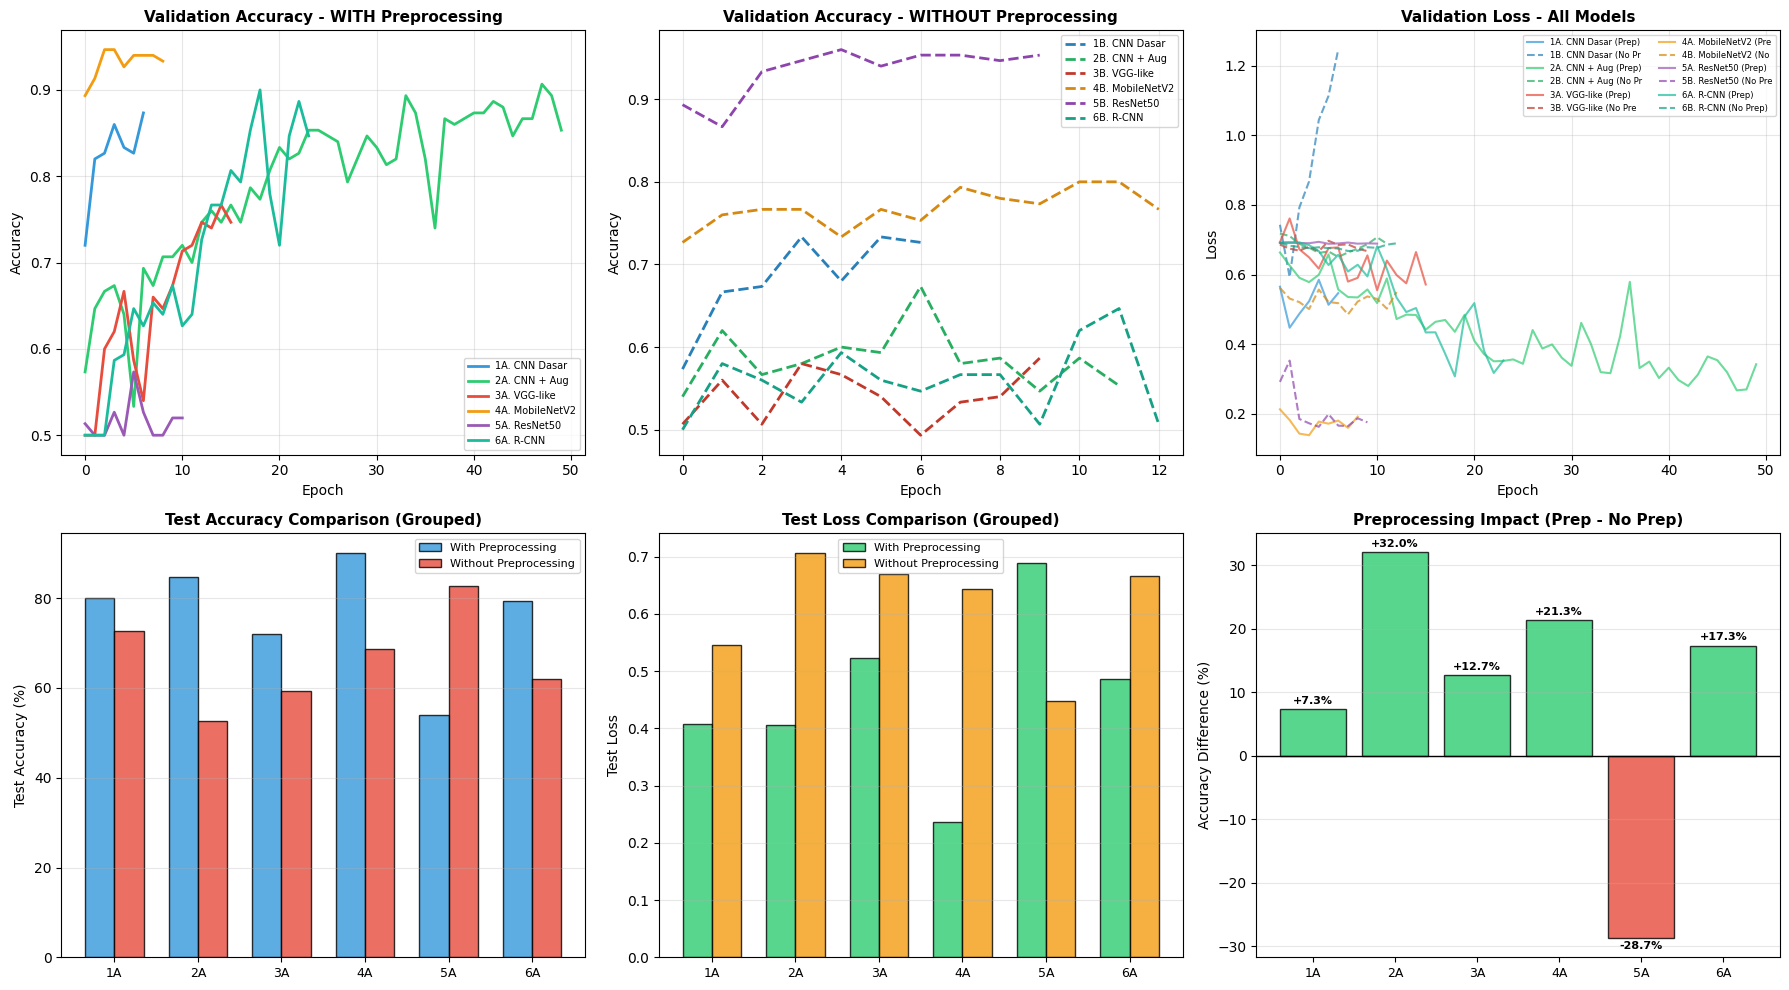

In [22]:
# Visualisasi Perbandingan - Training History
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Define colors for each model type
colors_map = {
    '1A': '#3498db', '1B': '#2980b9',
    '2A': '#2ecc71', '2B': '#27ae60',
    '3A': '#e74c3c', '3B': '#c0392b',
    '4A': '#f39c12', '4B': '#d68910',
    '5A': '#9b59b6', '5B': '#8e44ad',
    '6A': '#1abc9c', '6B': '#16a085'
}

# Plot 1: Accuracy Comparison (With Preprocessing)
ax1 = axes[0, 0]
for config_name, result in experiment_results.items():
    if "Prep)" in config_name and "No Prep)" not in config_name:
        history = result['history']
        color_key = config_name.split('.')[0]
        ax1.plot(history.history['val_accuracy'], 
                label=config_name.split('(')[0].strip(), 
                color=colors_map.get(color_key, '#95a5a6'),
                linewidth=2)

ax1.set_title('Validation Accuracy - WITH Preprocessing', fontsize=11, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(fontsize=7, loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy Comparison (Without Preprocessing)
ax2 = axes[0, 1]
for config_name, result in experiment_results.items():
    if "No Prep)" in config_name:
        history = result['history']
        color_key = config_name.split('.')[0]
        ax2.plot(history.history['val_accuracy'], 
                label=config_name.split('(')[0].strip(), 
                color=colors_map.get(color_key, '#95a5a6'),
                linewidth=2, linestyle='--')

ax2.set_title('Validation Accuracy - WITHOUT Preprocessing', fontsize=11, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(fontsize=7, loc='best')
ax2.grid(True, alpha=0.3)

# Plot 3: Loss Comparison
ax3 = axes[0, 2]
for config_name, result in experiment_results.items():
    history = result['history']
    color_key = config_name.split('.')[0]
    linestyle = '-' if ("Prep)" in config_name and "No Prep)" not in config_name) else '--'
    ax3.plot(history.history['val_loss'], 
            label=config_name[:20], 
            color=colors_map.get(color_key, '#95a5a6'),
            linewidth=1.5, linestyle=linestyle, alpha=0.7)

ax3.set_title('Validation Loss - All Models', fontsize=11, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend(fontsize=6, loc='best', ncol=2)
ax3.grid(True, alpha=0.3)

# Plot 4: Test Accuracy Bar Chart (Grouped by preprocessing)
ax4 = axes[1, 0]

# Separate configs by preprocessing - FIX: hanya ambil yang "Prep)" tapi bukan "No Prep)"
with_prep_configs = [c for c in experiment_results.keys() if "Prep)" in c and "No Prep)" not in c]
without_prep_configs = [c for c in experiment_results.keys() if "No Prep)" in c]

# Sort untuk memastikan urutan yang konsisten
with_prep_configs = sorted(with_prep_configs)
without_prep_configs = sorted(without_prep_configs)

x_pos = np.arange(len(with_prep_configs))
width = 0.35

with_prep_accs = [experiment_results[c]['test_accuracy']*100 for c in with_prep_configs]
without_prep_accs = [experiment_results[c]['test_accuracy']*100 for c in without_prep_configs]

bars1 = ax4.bar(x_pos - width/2, with_prep_accs, width, label='With Preprocessing', 
                color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax4.bar(x_pos + width/2, without_prep_accs, width, label='Without Preprocessing', 
                color='#e74c3c', alpha=0.8, edgecolor='black')

ax4.set_xticks(x_pos)
ax4.set_xticklabels([c.split('.')[0] for c in with_prep_configs], rotation=0, ha='center', fontsize=9)
ax4.set_ylabel('Test Accuracy (%)')
ax4.set_title('Test Accuracy Comparison (Grouped)', fontsize=11, fontweight='bold')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Test Loss Bar Chart
ax5 = axes[1, 1]

with_prep_losses = [experiment_results[c]['test_loss'] for c in with_prep_configs]
without_prep_losses = [experiment_results[c]['test_loss'] for c in without_prep_configs]

bars3 = ax5.bar(x_pos - width/2, with_prep_losses, width, label='With Preprocessing', 
                color='#2ecc71', alpha=0.8, edgecolor='black')
bars4 = ax5.bar(x_pos + width/2, without_prep_losses, width, label='Without Preprocessing', 
                color='#f39c12', alpha=0.8, edgecolor='black')

ax5.set_xticks(x_pos)
ax5.set_xticklabels([c.split('.')[0] for c in with_prep_configs], rotation=0, ha='center', fontsize=9)
ax5.set_ylabel('Test Loss')
ax5.set_title('Test Loss Comparison (Grouped)', fontsize=11, fontweight='bold')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Preprocessing Impact (Difference)
ax6 = axes[1, 2]

differences = [with_prep_accs[i] - without_prep_accs[i] for i in range(len(with_prep_accs))]
colors_diff = ['#2ecc71' if d > 0 else '#e74c3c' for d in differences]

bars5 = ax6.bar(x_pos, differences, color=colors_diff, alpha=0.8, edgecolor='black')

ax6.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax6.set_xticks(x_pos)
ax6.set_xticklabels([c.split('.')[0] for c in with_prep_configs], rotation=0, ha='center', fontsize=9)
ax6.set_ylabel('Accuracy Difference (%)')
ax6.set_title('Preprocessing Impact (Prep - No Prep)', fontsize=11, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, (bar, diff) in enumerate(zip(bars5, differences)):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.5 if diff > 0 else -0.5), 
             f'{diff:+.1f}%', ha='center', va='bottom' if diff > 0 else 'top', 
             fontweight='bold', fontsize=8)

plt.tight_layout()
plt.show()

In [23]:
# DataFrame untuk perbandingan detail
comparison_df = pd.DataFrame({
    'Konfigurasi': list(experiment_results.keys()),
    'Preprocessing': ['Yes' if 'Prep)' in k else 'No' for k in experiment_results.keys()],
    'Test Accuracy (%)': [result['test_accuracy']*100 for result in experiment_results.values()],
    'Test Loss': [result['test_loss'] for result in experiment_results.values()],
    'Epochs Run': [len(result['history'].history['loss']) for result in experiment_results.values()],
    'Final Train Acc (%)': [result['history'].history['accuracy'][-1]*100 for result in experiment_results.values()],
    'Final Val Acc (%)': [result['history'].history['val_accuracy'][-1]*100 for result in experiment_results.values()]
})

comparison_df = comparison_df.sort_values('Test Accuracy (%)', ascending=False)
print("\n" + "="*125)
print("TABEL DETAIL PERBANDINGAN 12 KONFIGURASI (Sorted by Test Accuracy)")
print("="*125)
print(comparison_df.to_string(index=False))
print("="*125)

# Statistik preprocessing
print("\n" + "="*125)
print("STATISTIK BERDASARKAN PREPROCESSING")
print("="*125)
prep_stats = comparison_df.groupby('Preprocessing')['Test Accuracy (%)'].agg(['mean', 'std', 'min', 'max'])
print(prep_stats)
print("="*125)


TABEL DETAIL PERBANDINGAN 12 KONFIGURASI (Sorted by Test Accuracy)
              Konfigurasi Preprocessing  Test Accuracy (%)  Test Loss  Epochs Run  Final Train Acc (%)  Final Val Acc (%)
   4A. MobileNetV2 (Prep)           Yes          89.999998   0.236613           9            99.571431          93.333334
     2A. CNN + Aug (Prep)           Yes          84.666669   0.406227          50            81.857145          85.333335
   5B. ResNet50 (No Prep)           Yes          82.666665   0.447824          10            97.428572          95.333332
     1A. CNN Dasar (Prep)           Yes          80.000001   0.406878           7           100.000000          87.333333
         6A. R-CNN (Prep)           Yes          79.333335   0.487048          24            90.142858          84.666669
  1B. CNN Dasar (No Prep)           Yes          72.666669   0.546016           7           100.000000          72.666669
      3A. VGG-like (Prep)           Yes          72.000003   0.522713         

## 3.8. Evaluasi Detail Model Terbaik

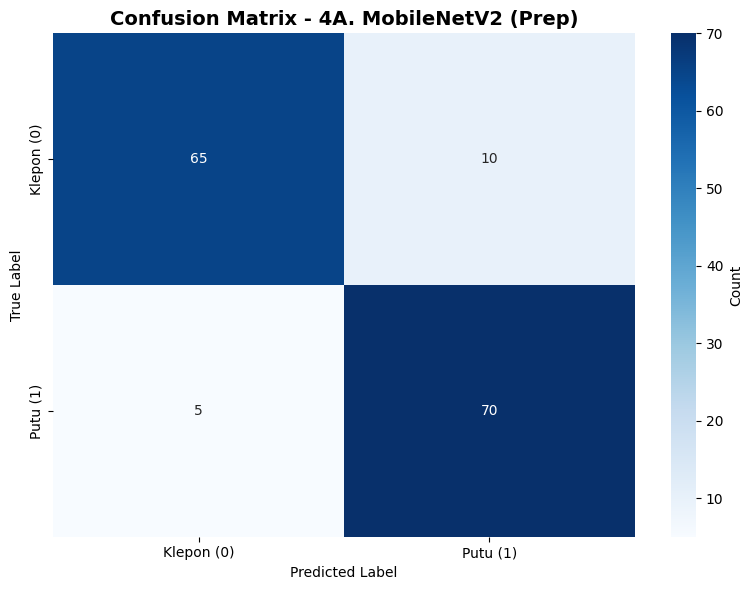


CLASSIFICATION REPORT - 4A. MobileNetV2 (Prep)
              precision    recall  f1-score   support

  Klepon (0)       0.93      0.87      0.90        75
    Putu (1)       0.88      0.93      0.90        75

    accuracy                           0.90       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.90      0.90      0.90       150



In [24]:
# Confusion Matrix dan Classification Report untuk model terbaik
best_model = best_config[1]['model']

# Tentukan generator yang sesuai dengan preprocessing model terbaik
if "Prep)" in best_config[0]:
    eval_generator = test_generator
    eval_generator.reset()
else:
    eval_generator = test_generator_no_prep
    eval_generator.reset()

y_pred_probs = best_model.predict(eval_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = eval_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Klepon (0)', 'Putu (1)'], 
            yticklabels=['Klepon (0)', 'Putu (1)'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_config[0]}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification Report
print("\n" + "="*70)
print(f"CLASSIFICATION REPORT - {best_config[0]}")
print("="*70)
print(classification_report(y_true, y_pred, target_names=['Klepon (0)', 'Putu (1)']))
print("="*70)

## 3.9. Save Model Terbaik

In [25]:
# Save model terbaik
best_model_name = best_config[0].replace('Config ', '').replace(':', '').replace(' ', '_').lower()
filename = f'model_best_{best_model_name}.h5'

best_model.save(filename)
print("\n" + "="*70)
print("MODEL TERBAIK BERHASIL DISIMPAN")
print("="*70)
print(f"   Filename     : {filename}")
print(f"   Konfigurasi  : {best_config[0]}")
print(f"   Test Accuracy: {best_config[1]['test_accuracy']*100:.2f}%")
print(f"   Test Loss    : {best_config[1]['test_loss']:.4f}")
print("="*70)


MODEL TERBAIK BERHASIL DISIMPAN
   Filename     : model_best_4a._mobilenetv2_(prep).h5
   Konfigurasi  : 4A. MobileNetV2 (Prep)
   Test Accuracy: 90.00%
   Test Loss    : 0.2366
